In [1]:
import time
import argparse
import scipy.sparse as sp
import numpy as np
import torch
import ipdb
from scipy.io import loadmat
import networkx as nx
import multiprocessing as mp
import torch.nn.functional as F
from functools import partial
import random
from sklearn.metrics import roc_auc_score, f1_score
from copy import deepcopy
from scipy.spatial.distance import pdist,squareform
import torch.nn as nn
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn import init
import torch.optim as optim
import networkx as nx
import tensorflow as tf
import pandas as pd

In [2]:
def split_arti(labels, c_train_num):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)
    c_num_mat[:,1] = 25
    c_num_mat[:,2] = 55

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        train_idx = train_idx + c_idx[:c_train_num[i]]
        c_num_mat[i,0] = c_train_num[i]

        val_idx = val_idx + c_idx[c_train_num[i]:(c_train_num[i]+int(c_train_num[i]*.2))]
        test_idx = test_idx + c_idx[int(c_train_num[i]+(c_train_num[i]*.2)):]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [3]:
def src_upsample(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            for j in range(c_portion):
                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            for j in range(c_portion):
                num = int(new_chosen.shape[0])
                new_chosen = new_chosen[:num]

                if chosen is None:
                    chosen = new_chosen
                else:
                    chosen = torch.cat((chosen, new_chosen), 0)
            
            num = int(new_chosen.shape[0]*portion_rest)
            new_chosen = new_chosen[:num]

            if chosen is None:
                chosen = new_chosen
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(features[chosen,:])
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [4]:
def src_smote(adj,features,labels,idx_train, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    adj_back = adj
    chosen = None
    new_features = None

    #ipdb.set_trace()
    avg_number = int(idx_train.shape[0]/(c_largest+1))

    for i in range(im_class_num):
        new_chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        if portion == 0:#refers to even distribution
            c_portion = int(avg_number/new_chosen.shape[0])

            portion_rest = (avg_number/new_chosen.shape[0]) - c_portion

        else:
            c_portion = int(portion)
            portion_rest = portion-c_portion
            
        for j in range(c_portion):
            num = int(new_chosen.shape[0])
            new_chosen = new_chosen[:num]

            chosen_embed = features[new_chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

            if chosen is None:
                chosen = new_chosen
                new_features = embed
            else:
                chosen = torch.cat((chosen, new_chosen), 0)
                new_features = torch.cat((new_features, embed),0)
            
        num = int(new_chosen.shape[0]*portion_rest)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen,:]
        distance = squareform(pdist(chosen_embed.detach()))
        np.fill_diagonal(distance,distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)
            
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:]-chosen_embed)*interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed),0)
            

    add_num = chosen.shape[0]
    new_adj = adj_back.new(torch.Size((adj_back.shape[0]+add_num, adj_back.shape[0]+add_num)))
    new_adj[:adj_back.shape[0], :adj_back.shape[0]] = adj_back[:,:]
    new_adj[adj_back.shape[0]:, :adj_back.shape[0]] = adj_back[chosen,:]
    new_adj[:adj_back.shape[0], adj_back.shape[0]:] = adj_back[:,chosen]
    new_adj[adj_back.shape[0]:, adj_back.shape[0]:] = adj_back[chosen,:][:,chosen]

    #ipdb.set_trace()
    features_append = deepcopy(new_features)
    labels_append = deepcopy(labels[chosen])
    idx_new = np.arange(adj_back.shape[0], adj_back.shape[0]+add_num)
    idx_train_append = idx_train.new(idx_new)

    features = torch.cat((features,features_append), 0)
    labels = torch.cat((labels,labels_append), 0)
    idx_train = torch.cat((idx_train,idx_train_append), 0)
    adj = new_adj

    return adj, features, labels, idx_train

In [5]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [6]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        #for 3_D batch, need a loop!!!


        if self.bias is not None:
            return output + self.bias
        else:
            return output

#Multihead attention layer
class MultiHead(Module):#currently, allowed for only one sample each time. As no padding mask is required.
    def __init__(
        self,
        input_dim,
        num_heads,
        kdim=None,
        vdim=None,
        embed_dim = 128,#should equal num_heads*head dim
        v_embed_dim = None,
        dropout=0.1,
        bias=True,
    ):
        super(MultiHead, self).__init__()
        self.input_dim = input_dim
        self.kdim = kdim if kdim is not None else input_dim
        self.vdim = vdim if vdim is not None else input_dim
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.v_embed_dim = v_embed_dim if v_embed_dim is not None else embed_dim

        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.bias = bias
        assert (
            self.head_dim * num_heads == self.embed_dim
        ), "embed_dim must be divisible by num_heads"

        assert self.v_embed_dim % num_heads ==0, "v_embed_dim must be divisible by num_heads"

        self.scaling = self.head_dim ** -0.5


        self.q_proj = nn.Linear(self.input_dim, self.embed_dim, bias=bias)
        self.k_proj = nn.Linear(self.kdim, self.embed_dim, bias=bias)
        self.v_proj = nn.Linear(self.vdim, self.v_embed_dim, bias=bias)

        self.out_proj = nn.Linear(self.v_embed_dim, self.v_embed_dim//self.num_heads, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        if True:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)
        else:
            nn.init.normal_(self.k_proj.weight)
            nn.init.normal_(self.v_proj.weight)
            nn.init.normal_(self.q_proj.weight)

        nn.init.normal_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)

        if self.bias:
            nn.init.constant_(self.k_proj.bias, 0.)
            nn.init.constant_(self.v_proj.bias, 0.)
            nn.init.constant_(self.q_proj.bias, 0.)

    def forward(
        self,
        query,
        key,
        value,
        need_weights: bool = False,
        need_head_weights: bool = False,
    ):
        """Input shape: Time x Batch x Channel
        Args:
            need_weights (bool, optional): return the attention weights,
                averaged over heads (default: False).
            need_head_weights (bool, optional): return the attention
                weights for each head. Implies *need_weights*. Default:
                return the average attention weights over all heads.
        """
        if need_head_weights:
            need_weights = True

        batch_num, node_num, input_dim = query.size()

        assert key is not None and value is not None

        #project input
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)
        q = q * self.scaling

        #compute attention
        q = q.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        k = k.view(batch_num, node_num, self.num_heads, self.head_dim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.head_dim)
        v = v.view(batch_num, node_num, self.num_heads, self.vdim).transpose(-2,-3).contiguous().view(batch_num*self.num_heads, node_num, self.vdim)
        attn_output_weights = torch.bmm(q, k.transpose(-1,-2))
        attn_output_weights = F.softmax(attn_output_weights, dim=-1)

        #drop out
        attn_output_weights = F.dropout(attn_output_weights, p=self.dropout, training=self.training)

        #collect output
        attn_output = torch.bmm(attn_output_weights, v)
        attn_output = attn_output.view(batch_num, self.num_heads, node_num, self.vdim).transpose(-2,-3).contiguous().view(batch_num, node_num, self.v_embed_dim)
        attn_output = self.out_proj(attn_output)


        if need_weights:
            attn_output_weights = attn_output_weights #view: (batch_num, num_heads, node_num, node_num)
            return attn_output, attn_output_weights.sum(dim=1) / self.num_heads
        else:
            return attn_output


#Graphsage layer
class SageConv(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, in_features, out_features, bias=False):
        super(SageConv, self).__init__()

        self.proj = nn.Linear(in_features*2, out_features, bias=bias)

        self.reset_parameters()

        #print("note: for dense graph in graphsage, require it normalized.")

    def reset_parameters(self):

        nn.init.normal_(self.proj.weight)

        if self.proj.bias is not None:
            nn.init.constant_(self.proj.bias, 0.)

    def forward(self, features, adj):
        """
        Args:
            adj: can be sparse or dense matrix.
        """

        #fuse info from neighbors. to be added:
        if not isinstance(adj, torch.sparse.FloatTensor):
            if len(adj.shape) == 3:
                neigh_feature = torch.bmm(adj, features) / (adj.sum(dim=1).reshape((adj.shape[0], adj.shape[1],-1))+1)
            else:
                neigh_feature = torch.mm(adj, features) / (adj.sum(dim=1).reshape(adj.shape[0], -1)+1)
        else:
            #print("spmm not implemented for batch training. Note!")
            
            neigh_feature = torch.spmm(adj, features) / (adj.to_dense().sum(dim=1).reshape(adj.shape[0], -1)+1)

        #perform conv
        data = torch.cat([features,neigh_feature], dim=-1)
        combined = self.proj(data)

        return combined

#GraphAT layers

class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        if isinstance(adj, torch.sparse.FloatTensor):
            adj = adj.to_dense()

        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'


class SpecialSpmmFunction(torch.autograd.Function):
    """Special function for only sparse region backpropataion layer."""
    @staticmethod
    def forward(ctx, indices, values, shape, b):
        assert indices.requires_grad == False
        a = torch.sparse_coo_tensor(indices, values, shape)
        ctx.save_for_backward(a, b)
        ctx.N = shape[0]
        return torch.matmul(a, b)

    @staticmethod
    def backward(ctx, grad_output):
        a, b = ctx.saved_tensors
        grad_values = grad_b = None
        if ctx.needs_input_grad[1]:
            grad_a_dense = grad_output.matmul(b.t())
            edge_idx = a._indices()[0, :] * ctx.N + a._indices()[1, :]
            grad_values = grad_a_dense.view(-1)[edge_idx]
        if ctx.needs_input_grad[3]:
            grad_b = a.t().matmul(grad_output)
        return None, grad_values, None, grad_b


class SpecialSpmm(nn.Module):
    def forward(self, indices, values, shape, b):
        return SpecialSpmmFunction.apply(indices, values, shape, b)

    
class SpGraphAttentionLayer(nn.Module):
    """
    Sparse version GAT layer, similar to https://arxiv.org/abs/1710.10903
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(SpGraphAttentionLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_normal_(self.W.data, gain=1.414)
                
        self.a = nn.Parameter(torch.zeros(size=(1, 2*out_features)))
        nn.init.xavier_normal_(self.a.data, gain=1.414)

        self.dropout = nn.Dropout(dropout)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
        self.special_spmm = SpecialSpmm()

    def forward(self, input, adj):
        dv = 'cuda' if input.is_cuda else 'cpu'

        N = input.size()[0]
        edge = adj.nonzero().t()

        h = torch.mm(input, self.W)
        # h: N x out
        assert not torch.isnan(h).any()

        # Self-attention on the nodes - Shared attention mechanism
        edge_h = torch.cat((h[edge[0, :], :], h[edge[1, :], :]), dim=1).t()
        # edge: 2*D x E

        edge_e = torch.exp(-self.leakyrelu(self.a.mm(edge_h).squeeze()))
        assert not torch.isnan(edge_e).any()
        # edge_e: E

        e_rowsum = self.special_spmm(edge, edge_e, torch.Size([N, N]), torch.ones(size=(N,1), device=dv))
        # e_rowsum: N x 1

        edge_e = self.dropout(edge_e)
        # edge_e: E

        h_prime = self.special_spmm(edge, edge_e, torch.Size([N, N]), h)
        assert not torch.isnan(h_prime).any()
        # h_prime: N x out
        
        h_prime = h_prime.div(e_rowsum)
        # h_prime: N x out
        assert not torch.isnan(h_prime).any()

        if self.concat:
            # if this layer is not last layer,
            return F.elu(h_prime)
        else:
            # if this layer is last layer,
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'




#--------------
### models ###
#--------------

#gcn_encode
class GCN_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class GCN_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(GCN_En2, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class GCN_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(GCN_Classifier, self).__init__()

        self.gc1 = GraphConvolution(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x

#sage model

class Sage_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En, self).__init__()

        self.sage1 = SageConv(nfeat, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        return x

class Sage_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(Sage_En2, self).__init__()

        self.sage1 = SageConv(nfeat, nhid)
        self.sage2 = SageConv(nhid, nembed)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.sage2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        return x

class Sage_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Sage_Classifier, self).__init__()

        self.sage1 = SageConv(nembed, nhid)
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = F.relu(self.sage1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.mlp(x)

        return x


#GAT model

class GAT_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En, self).__init__()

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):

        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))

        return x

class GAT_En2(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout, alpha=0.2, nheads=8):
        super(GAT_En2, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nembed)
        self.dropout = dropout

        self.attentions_2 = [GraphAttentionLayer(nembed, nembed, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions_2):
            self.add_module('attention2_{}'.format(i), attention)

        self.out_proj_2 = nn.Linear(nembed * nheads, nembed)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.out_proj.weight,std=0.05)
        nn.init.normal_(self.out_proj_2.weight,std=0.05)


    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = torch.cat([att(x, adj) for att in self.attentions_2], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj_2(x))
        return x

class GAT_Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout, alpha=0.2, nheads=8):
        super(GAT_Classifier, self).__init__()

        
        self.attentions = [GraphAttentionLayer(nembed, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_proj = nn.Linear(nhid * nheads, nhid)

        self.dropout = dropout
        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)
        nn.init.normal_(self.out_proj.weight,std=0.05)

    def forward(self, x, adj):
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_proj(x))
        x = self.mlp(x)

        return x

class MLP_En(nn.Module):
    def __init__(self, nfeat, nhid, nembed, dropout):
        super(MLP_En, self).__init__()

        self.mlp1 = nn.Linear(nfeat, nembed)
        self.dropout = dropout
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp1.weight,std=0.05)
    def forward(self, x, adj):
        x = F.relu(self.mlp1(x))
        x = F.dropout(x, self.dropout, training=self.training)
        return x


class Classifier(nn.Module):
    def __init__(self, nembed, nhid, nclass, dropout):
        super(Classifier, self).__init__()

        self.mlp = nn.Linear(nhid, nclass)
        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.mlp.weight,std=0.05)

    def forward(self, x, adj):
        x = self.mlp(x)

        return x

class Decoder(Module):
    """
    Simple Graphsage layer
    """

    def __init__(self, nembed, dropout=0.1):
        super(Decoder, self).__init__()
        self.dropout = dropout

        self.de_weight = Parameter(torch.FloatTensor(nembed, nembed))

        self.reset_parameters()


    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.de_weight.size(1))
        self.de_weight.data.uniform_(-stdv, stdv)


    def forward(self, node_embed):
        
        combine = F.linear(node_embed, self.de_weight)
        adj_out = torch.sigmoid(torch.mm(combine, combine.transpose(-1,-2)))

        return adj_out

In [7]:
def split_genuine(labels):
    #labels: n-dim Longtensor, each element in [0,...,m-1].
    #cora: m=7
    num_classes = len(set(labels.tolist()))
    c_idxs = [] # class-wise index
    train_idx = []
    val_idx = []
    test_idx = []
    c_num_mat = np.zeros((num_classes,3)).astype(int)

    for i in range(num_classes):
        c_idx = (labels==i).nonzero()[:,-1].tolist()
        c_num = len(c_idx)
        print('{:d}-th class sample number: {:d}'.format(i,len(c_idx)))
        random.shuffle(c_idx)
        c_idxs.append(c_idx)

        if c_num <4:
            if c_num < 3:
                print("too small class type")
                ipdb.set_trace()
            c_num_mat[i,0] = 1
            c_num_mat[i,1] = 1
            c_num_mat[i,2] = 1
        else:
            c_num_mat[i,0] = int(c_num/4)
            c_num_mat[i,1] = int(c_num/4)
            c_num_mat[i,2] = int(c_num/2)


        train_idx = train_idx + c_idx[:c_num_mat[i,0]]

        val_idx = val_idx + c_idx[c_num_mat[i,0]:c_num_mat[i,0]+c_num_mat[i,1]]
        test_idx = test_idx + c_idx[c_num_mat[i,0]+c_num_mat[i,1]:c_num_mat[i,0]+c_num_mat[i,1]+c_num_mat[i,2]]

    random.shuffle(train_idx)

    #ipdb.set_trace()

    train_idx = torch.LongTensor(train_idx)
    val_idx = torch.LongTensor(val_idx)
    test_idx = torch.LongTensor(test_idx)
    #c_num_mat = torch.LongTensor(c_num_mat)


    return train_idx, val_idx, test_idx, c_num_mat


In [8]:
data=pd.read_csv("interactions_smote.csv")
data['edge']=data['Gene Symbol']+',' +data['Interactor Symbol']
Graphtype = nx.Graph()
data['edge']=data['edge'].astype(str)
g = nx.parse_edgelist(data['edge'], delimiter=',', create_using=Graphtype,)
adj=nx.adjacency_matrix(g,weight=None)
adj=adj.toarray()
node_features = np.loadtxt('node_features_smote.txt')
#labels = np.loadtxt('Multi-Labels.txt')
#labels = np.loadtxt('Labels.txt')
labels = np.loadtxt('syndromic-Labels.txt')

In [9]:
labels=torch.LongTensor(labels)
features=torch.LongTensor(node_features)
adj=torch.LongTensor(adj)
class_sample_num = 6000
c_train_num = []
for i in range(labels.max().item() + 1):
    if i > labels.max().item()-1: #only imbalance the last classes
        c_train_num.append(int(class_sample_num))

    else:
        c_train_num.append(class_sample_num)

In [10]:
#for i in range(4):
for i in range(6):
#for i in range(7):
        print(i)
        print("-----------------------------------")
        idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)
        #adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=3)
        adj,features,labels,idx_train = src_upsample(adj,features,labels,idx_train,portion=1, im_class_num=1)
        print("-----------------------------------")

0
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 169
-----------------------------------
1
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 338
-----------------------------------
2
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 676
-----------------------------------
3
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 1352
-----------------------------------
4
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 2704
-----------------------------------
5
-----------------------------------
0-th class sample number: 12047
1-th class sample number: 5408
-----------------------------------


In [11]:
idx_train, idx_val, idx_test, class_num_mat= split_arti(labels, c_train_num)

0-th class sample number: 12047
1-th class sample number: 10816


In [12]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [13]:
encoder = MLP_En(nfeat=features.shape[1],
        nhid=1,
        nembed=1,
        dropout=0)
classifier = Classifier(nembed=1, 
        nhid=1, 
        nclass=labels.max().item() + 1, 
        dropout=0)
decoder = Decoder(nembed=1,
        dropout=0)


optimizer_en = optim.AdamW(encoder.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)
optimizer_cls = optim.AdamW(classifier.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)
optimizer_de = optim.AdamW(decoder.parameters(),
                       lr=0.001,weight_decay=5e-4,eps=1e-04)

In [14]:
features.shape[1]

472

In [15]:
def recon_upsample(embed, labels, idx_train, adj=None, portion=1.0, im_class_num=3):
    c_largest = labels.max().item()
    avg_number = int(idx_train.shape[0]/(c_largest+1))
    #ipdb.set_trace()
    adj_new = None

    for i in range(im_class_num):
        chosen = idx_train[(labels==(c_largest-i))[idx_train]]
        num = int(chosen.shape[0]*portion)
        if portion == 0:
            c_portion = int(avg_number/chosen.shape[0])
            num = chosen.shape[0]
        else:
            c_portion = 1

        for j in range(c_portion):
            chosen = chosen[:num]

            chosen_embed = embed[chosen,:]
            distance = squareform(pdist(chosen_embed.detach()))
            np.fill_diagonal(distance,distance.max()+100)

            idx_neighbor = distance.argmin(axis=-1)
            
            interp_place = random.random()
            new_embed = embed[chosen,:] + (chosen_embed[idx_neighbor[:],:]-embed[chosen,:])*interp_place


            new_labels = labels.new(torch.Size((chosen.shape[0],1))).reshape(-1).fill_(c_largest-i)
            idx_new = np.arange(embed.shape[0], embed.shape[0]+chosen.shape[0])
            idx_train_append = idx_train.new(idx_new)

            embed = torch.cat((embed,new_embed), 0)
            labels = torch.cat((labels,new_labels), 0)
            idx_train = torch.cat((idx_train,idx_train_append), 0)

            if adj is not None:
                if adj_new is None:
                    adj_new = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                else:
                    temp = adj.new(torch.clamp(adj[chosen,:] + adj[idx_neighbor,:], min=0.0, max = 1.0))
                    adj_new = torch.cat((adj_new, temp), 0)

    if adj is not None:
        add_num = adj_new.shape[0]
        new_adj = adj.new(torch.Size((adj.shape[0]+add_num, adj.shape[0]+add_num))).fill_(0.0)
        new_adj[:adj.shape[0], :adj.shape[0]] = adj[:,:]
        new_adj[adj.shape[0]:, :adj.shape[0]] = adj_new[:,:]
        new_adj[:adj.shape[0], adj.shape[0]:] = torch.transpose(adj_new, 0, 1)[:,:]

        return embed, labels, idx_train, new_adj.detach()

    else:
        return embed, labels, idx_train

In [16]:
def train(epoch):
    t = time.time()
    encoder.train()
    classifier.train()
    decoder.train()
    optimizer_en.zero_grad()
    optimizer_cls.zero_grad()
    optimizer_de.zero_grad()

    embed = encoder(features, adj)

    #perform SMOTE in embedding space
    labels_new = labels
    idx_train_new = idx_train
    adj_new = adj

   
    #ipdb.set_trace()
    output = classifier(embed, adj_new)

    loss_train = F.cross_entropy(output[idx_train_new], labels_new[idx_train_new])
    
    acc_train = accuracy(output[idx_train], labels_new[idx_train])
    loss = loss_train
    loss_rec = loss_train
    loss.backward()
    optimizer_en.step()

    optimizer_cls.step()
    loss_val = F.cross_entropy(output[idx_val], labels[idx_val])
    
    acc_val = accuracy(output[idx_val], labels[idx_val])

    print('Epoch: {:05d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_rec: {:.4f}'.format(loss_rec.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test(epoch = 0):
    encoder.eval()
    classifier.eval()
    decoder.eval()
    embed = encoder(features, adj)
    output = classifier(embed, adj)
    loss_test = F.cross_entropy(output[idx_test], labels[idx_test])
    
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

  

    '''
    if epoch==40:
        torch
    '''
    return output


def save_model(epoch):
    saved_content = {}

    saved_content['encoder'] = encoder.state_dict()
    saved_content['decoder'] = decoder.state_dict()
    saved_content['classifier'] = classifier.state_dict()

    torch.save(saved_content, 'model_checkpoint.pth')

    return

def load_model(filename):
    loaded_content = torch.load('checkpoint/{}/{}.pth')

    encoder.load_state_dict(loaded_content['encoder'])
    decoder.load_state_dict(loaded_content['decoder'])
    classifier.load_state_dict(loaded_content['classifier'])

    print("successfully loaded: "+ filename)

    return

In [17]:
encoder = encoder.cuda()
classifier = classifier.cuda()
decoder = decoder.cuda()
labels = labels.cuda()
idx_train = idx_train.cuda()
idx_val = idx_val.cuda()
idx_test = idx_test.cuda()

In [18]:
adj = torch.tensor(adj, dtype=torch.float)
features = torch.tensor(features, dtype=torch.float)
features = features.cuda()
adj = adj.cuda()

C:\Users\Kyle\AppData\Local\Temp\ipykernel_30816\4161052455.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj, dtype=torch.float)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_30816\4161052455.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [19]:

t_total = time.time()
for epoch in range(3000):
    train(epoch)

    if epoch % 10 == 0:
        output=test(epoch)

    if epoch % 100 == 0:
        save_model(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
output=test()

Epoch: 00001 loss_train: 0.7013 loss_rec: 0.7013 acc_train: 0.5000 loss_val: 0.7013 acc_val: 0.5000 time: 0.6203s
Test set results: loss= 0.7194 accuracy= 0.4273
Epoch: 00002 loss_train: 0.7011 loss_rec: 0.7011 acc_train: 0.5000 loss_val: 0.7011 acc_val: 0.5000 time: 0.0010s
Epoch: 00003 loss_train: 0.7010 loss_rec: 0.7010 acc_train: 0.5000 loss_val: 0.7010 acc_val: 0.5000 time: 0.0010s
Epoch: 00004 loss_train: 0.7009 loss_rec: 0.7009 acc_train: 0.5000 loss_val: 0.7009 acc_val: 0.5000 time: 0.0010s
Epoch: 00005 loss_train: 0.7007 loss_rec: 0.7007 acc_train: 0.5000 loss_val: 0.7007 acc_val: 0.5000 time: 0.0010s
Epoch: 00006 loss_train: 0.7006 loss_rec: 0.7006 acc_train: 0.5000 loss_val: 0.7006 acc_val: 0.5000 time: 0.0010s
Epoch: 00007 loss_train: 0.7005 loss_rec: 0.7005 acc_train: 0.5000 loss_val: 0.7005 acc_val: 0.5000 time: 0.0010s
Epoch: 00008 loss_train: 0.7003 loss_rec: 0.7003 acc_train: 0.5000 loss_val: 0.7003 acc_val: 0.5000 time: 0.0015s
Epoch: 00009 loss_train: 0.7002 loss_rec

Epoch: 00185 loss_train: 0.6673 loss_rec: 0.6673 acc_train: 0.7442 loss_val: 0.6675 acc_val: 0.7492 time: 0.0010s
Epoch: 00186 loss_train: 0.6671 loss_rec: 0.6671 acc_train: 0.7443 loss_val: 0.6672 acc_val: 0.7492 time: 0.0010s
Epoch: 00187 loss_train: 0.6668 loss_rec: 0.6668 acc_train: 0.7452 loss_val: 0.6669 acc_val: 0.7500 time: 0.0010s
Epoch: 00188 loss_train: 0.6665 loss_rec: 0.6665 acc_train: 0.7454 loss_val: 0.6666 acc_val: 0.7500 time: 0.0010s
Epoch: 00189 loss_train: 0.6662 loss_rec: 0.6662 acc_train: 0.7453 loss_val: 0.6664 acc_val: 0.7500 time: 0.0010s
Epoch: 00190 loss_train: 0.6659 loss_rec: 0.6659 acc_train: 0.7452 loss_val: 0.6661 acc_val: 0.7500 time: 0.0010s
Epoch: 00191 loss_train: 0.6656 loss_rec: 0.6656 acc_train: 0.7452 loss_val: 0.6658 acc_val: 0.7500 time: 0.0015s
Test set results: loss= 0.6631 accuracy= 0.7613
Epoch: 00192 loss_train: 0.6653 loss_rec: 0.6653 acc_train: 0.7452 loss_val: 0.6655 acc_val: 0.7504 time: 0.0010s
Epoch: 00193 loss_train: 0.6650 loss_rec

Epoch: 00311 loss_train: 0.6246 loss_rec: 0.6246 acc_train: 0.7720 loss_val: 0.6253 acc_val: 0.7742 time: 0.0020s
Test set results: loss= 0.6228 accuracy= 0.7782
Epoch: 00312 loss_train: 0.6242 loss_rec: 0.6242 acc_train: 0.7720 loss_val: 0.6249 acc_val: 0.7742 time: 0.0015s
Epoch: 00313 loss_train: 0.6238 loss_rec: 0.6238 acc_train: 0.7719 loss_val: 0.6246 acc_val: 0.7742 time: 0.0020s
Epoch: 00314 loss_train: 0.6234 loss_rec: 0.6234 acc_train: 0.7717 loss_val: 0.6242 acc_val: 0.7742 time: 0.0015s
Epoch: 00315 loss_train: 0.6231 loss_rec: 0.6231 acc_train: 0.7717 loss_val: 0.6238 acc_val: 0.7742 time: 0.0020s
Epoch: 00316 loss_train: 0.6227 loss_rec: 0.6227 acc_train: 0.7717 loss_val: 0.6234 acc_val: 0.7742 time: 0.0015s
Epoch: 00317 loss_train: 0.6223 loss_rec: 0.6223 acc_train: 0.7716 loss_val: 0.6231 acc_val: 0.7742 time: 0.0020s
Epoch: 00318 loss_train: 0.6220 loss_rec: 0.6220 acc_train: 0.7716 loss_val: 0.6227 acc_val: 0.7742 time: 0.0015s
Epoch: 00319 loss_train: 0.6216 loss_rec

Epoch: 00421 loss_train: 0.5835 loss_rec: 0.5835 acc_train: 0.7844 loss_val: 0.5848 acc_val: 0.7846 time: 0.0025s
Test set results: loss= 0.5848 accuracy= 0.7844
Epoch: 00422 loss_train: 0.5831 loss_rec: 0.5831 acc_train: 0.7845 loss_val: 0.5844 acc_val: 0.7846 time: 0.0020s
Epoch: 00423 loss_train: 0.5827 loss_rec: 0.5827 acc_train: 0.7843 loss_val: 0.5840 acc_val: 0.7846 time: 0.0020s
Epoch: 00424 loss_train: 0.5824 loss_rec: 0.5824 acc_train: 0.7844 loss_val: 0.5837 acc_val: 0.7846 time: 0.0015s
Epoch: 00425 loss_train: 0.5820 loss_rec: 0.5820 acc_train: 0.7841 loss_val: 0.5833 acc_val: 0.7846 time: 0.0020s
Epoch: 00426 loss_train: 0.5817 loss_rec: 0.5817 acc_train: 0.7841 loss_val: 0.5830 acc_val: 0.7842 time: 0.0020s
Epoch: 00427 loss_train: 0.5813 loss_rec: 0.5813 acc_train: 0.7841 loss_val: 0.5826 acc_val: 0.7842 time: 0.0020s
Epoch: 00428 loss_train: 0.5809 loss_rec: 0.5809 acc_train: 0.7843 loss_val: 0.5823 acc_val: 0.7846 time: 0.0020s
Epoch: 00429 loss_train: 0.5806 loss_rec

Epoch: 00531 loss_train: 0.5452 loss_rec: 0.5452 acc_train: 0.7805 loss_val: 0.5472 acc_val: 0.7792 time: 0.0020s
Test set results: loss= 0.5493 accuracy= 0.7794
Epoch: 00532 loss_train: 0.5449 loss_rec: 0.5449 acc_train: 0.7805 loss_val: 0.5469 acc_val: 0.7792 time: 0.0015s
Epoch: 00533 loss_train: 0.5446 loss_rec: 0.5446 acc_train: 0.7804 loss_val: 0.5466 acc_val: 0.7792 time: 0.0020s
Epoch: 00534 loss_train: 0.5443 loss_rec: 0.5443 acc_train: 0.7803 loss_val: 0.5463 acc_val: 0.7792 time: 0.0015s
Epoch: 00535 loss_train: 0.5439 loss_rec: 0.5439 acc_train: 0.7803 loss_val: 0.5460 acc_val: 0.7792 time: 0.0015s
Epoch: 00536 loss_train: 0.5436 loss_rec: 0.5436 acc_train: 0.7803 loss_val: 0.5456 acc_val: 0.7792 time: 0.0020s
Epoch: 00537 loss_train: 0.5433 loss_rec: 0.5433 acc_train: 0.7804 loss_val: 0.5453 acc_val: 0.7796 time: 0.0020s
Epoch: 00538 loss_train: 0.5430 loss_rec: 0.5430 acc_train: 0.7806 loss_val: 0.5450 acc_val: 0.7796 time: 0.0015s
Epoch: 00539 loss_train: 0.5427 loss_rec

Epoch: 00644 loss_train: 0.5125 loss_rec: 0.5125 acc_train: 0.7807 loss_val: 0.5149 acc_val: 0.7817 time: 0.0025s
Epoch: 00645 loss_train: 0.5122 loss_rec: 0.5122 acc_train: 0.7807 loss_val: 0.5147 acc_val: 0.7817 time: 0.0020s
Epoch: 00646 loss_train: 0.5120 loss_rec: 0.5120 acc_train: 0.7807 loss_val: 0.5144 acc_val: 0.7817 time: 0.0015s
Epoch: 00647 loss_train: 0.5117 loss_rec: 0.5117 acc_train: 0.7807 loss_val: 0.5142 acc_val: 0.7817 time: 0.0020s
Epoch: 00648 loss_train: 0.5114 loss_rec: 0.5114 acc_train: 0.7807 loss_val: 0.5139 acc_val: 0.7817 time: 0.0015s
Epoch: 00649 loss_train: 0.5112 loss_rec: 0.5112 acc_train: 0.7804 loss_val: 0.5137 acc_val: 0.7817 time: 0.0020s
Epoch: 00650 loss_train: 0.5109 loss_rec: 0.5109 acc_train: 0.7805 loss_val: 0.5134 acc_val: 0.7817 time: 0.0015s
Epoch: 00651 loss_train: 0.5107 loss_rec: 0.5107 acc_train: 0.7805 loss_val: 0.5132 acc_val: 0.7817 time: 0.0015s
Test set results: loss= 0.5170 accuracy= 0.7802
Epoch: 00652 loss_train: 0.5104 loss_rec

Epoch: 00757 loss_train: 0.4873 loss_rec: 0.4873 acc_train: 0.7821 loss_val: 0.4899 acc_val: 0.7821 time: 0.0020s
Epoch: 00758 loss_train: 0.4871 loss_rec: 0.4871 acc_train: 0.7821 loss_val: 0.4897 acc_val: 0.7821 time: 0.0015s
Epoch: 00759 loss_train: 0.4869 loss_rec: 0.4869 acc_train: 0.7821 loss_val: 0.4895 acc_val: 0.7821 time: 0.0020s
Epoch: 00760 loss_train: 0.4867 loss_rec: 0.4867 acc_train: 0.7821 loss_val: 0.4893 acc_val: 0.7821 time: 0.0015s
Epoch: 00761 loss_train: 0.4865 loss_rec: 0.4865 acc_train: 0.7851 loss_val: 0.4891 acc_val: 0.7846 time: 0.0020s
Test set results: loss= 0.4950 accuracy= 0.7832
Epoch: 00762 loss_train: 0.4863 loss_rec: 0.4863 acc_train: 0.7851 loss_val: 0.4890 acc_val: 0.7846 time: 0.0015s
Epoch: 00763 loss_train: 0.4861 loss_rec: 0.4861 acc_train: 0.7851 loss_val: 0.4888 acc_val: 0.7846 time: 0.0015s
Epoch: 00764 loss_train: 0.4859 loss_rec: 0.4859 acc_train: 0.7851 loss_val: 0.4886 acc_val: 0.7846 time: 0.0020s
Epoch: 00765 loss_train: 0.4858 loss_rec

Epoch: 00870 loss_train: 0.4684 loss_rec: 0.4684 acc_train: 0.7872 loss_val: 0.4713 acc_val: 0.7846 time: 0.0020s
Epoch: 00871 loss_train: 0.4683 loss_rec: 0.4683 acc_train: 0.7872 loss_val: 0.4712 acc_val: 0.7846 time: 0.0015s
Test set results: loss= 0.4787 accuracy= 0.7840
Epoch: 00872 loss_train: 0.4681 loss_rec: 0.4681 acc_train: 0.7872 loss_val: 0.4710 acc_val: 0.7846 time: 0.0015s
Epoch: 00873 loss_train: 0.4680 loss_rec: 0.4680 acc_train: 0.7872 loss_val: 0.4709 acc_val: 0.7846 time: 0.0020s
Epoch: 00874 loss_train: 0.4678 loss_rec: 0.4678 acc_train: 0.7872 loss_val: 0.4707 acc_val: 0.7846 time: 0.0015s
Epoch: 00875 loss_train: 0.4677 loss_rec: 0.4677 acc_train: 0.7872 loss_val: 0.4706 acc_val: 0.7846 time: 0.0020s
Epoch: 00876 loss_train: 0.4675 loss_rec: 0.4675 acc_train: 0.7872 loss_val: 0.4705 acc_val: 0.7846 time: 0.0015s
Epoch: 00877 loss_train: 0.4674 loss_rec: 0.4674 acc_train: 0.7872 loss_val: 0.4703 acc_val: 0.7846 time: 0.0020s
Epoch: 00878 loss_train: 0.4672 loss_rec

Epoch: 00982 loss_train: 0.4542 loss_rec: 0.4542 acc_train: 0.7901 loss_val: 0.4578 acc_val: 0.7850 time: 0.0030s
Epoch: 00983 loss_train: 0.4541 loss_rec: 0.4541 acc_train: 0.7901 loss_val: 0.4577 acc_val: 0.7850 time: 0.0020s
Epoch: 00984 loss_train: 0.4540 loss_rec: 0.4540 acc_train: 0.7902 loss_val: 0.4575 acc_val: 0.7850 time: 0.0020s
Epoch: 00985 loss_train: 0.4539 loss_rec: 0.4539 acc_train: 0.7903 loss_val: 0.4574 acc_val: 0.7846 time: 0.0015s
Epoch: 00986 loss_train: 0.4538 loss_rec: 0.4538 acc_train: 0.7903 loss_val: 0.4574 acc_val: 0.7846 time: 0.0020s
Epoch: 00987 loss_train: 0.4537 loss_rec: 0.4537 acc_train: 0.7901 loss_val: 0.4573 acc_val: 0.7842 time: 0.0015s
Epoch: 00988 loss_train: 0.4536 loss_rec: 0.4536 acc_train: 0.7901 loss_val: 0.4572 acc_val: 0.7842 time: 0.0030s
Epoch: 00989 loss_train: 0.4535 loss_rec: 0.4535 acc_train: 0.7901 loss_val: 0.4571 acc_val: 0.7842 time: 0.0015s
Epoch: 00990 loss_train: 0.4534 loss_rec: 0.4534 acc_train: 0.7901 loss_val: 0.4570 acc_

Epoch: 01094 loss_train: 0.4436 loss_rec: 0.4436 acc_train: 0.7900 loss_val: 0.4480 acc_val: 0.7846 time: 0.0020s
Epoch: 01095 loss_train: 0.4435 loss_rec: 0.4435 acc_train: 0.7900 loss_val: 0.4479 acc_val: 0.7846 time: 0.0015s
Epoch: 01096 loss_train: 0.4434 loss_rec: 0.4434 acc_train: 0.7900 loss_val: 0.4478 acc_val: 0.7846 time: 0.0020s
Epoch: 01097 loss_train: 0.4433 loss_rec: 0.4433 acc_train: 0.7900 loss_val: 0.4478 acc_val: 0.7846 time: 0.0020s
Epoch: 01098 loss_train: 0.4432 loss_rec: 0.4432 acc_train: 0.7900 loss_val: 0.4477 acc_val: 0.7846 time: 0.0015s
Epoch: 01099 loss_train: 0.4431 loss_rec: 0.4431 acc_train: 0.7900 loss_val: 0.4476 acc_val: 0.7846 time: 0.0020s
Epoch: 01100 loss_train: 0.4431 loss_rec: 0.4431 acc_train: 0.7900 loss_val: 0.4475 acc_val: 0.7846 time: 0.0015s
Epoch: 01101 loss_train: 0.4430 loss_rec: 0.4430 acc_train: 0.7900 loss_val: 0.4475 acc_val: 0.7846 time: 0.0020s
Test set results: loss= 0.4576 accuracy= 0.7871
Epoch: 01102 loss_train: 0.4429 loss_rec

Epoch: 01206 loss_train: 0.4355 loss_rec: 0.4355 acc_train: 0.7913 loss_val: 0.4411 acc_val: 0.7883 time: 0.0020s
Epoch: 01207 loss_train: 0.4354 loss_rec: 0.4354 acc_train: 0.7913 loss_val: 0.4411 acc_val: 0.7883 time: 0.0020s
Epoch: 01208 loss_train: 0.4354 loss_rec: 0.4354 acc_train: 0.7913 loss_val: 0.4410 acc_val: 0.7883 time: 0.0020s
Epoch: 01209 loss_train: 0.4353 loss_rec: 0.4353 acc_train: 0.7913 loss_val: 0.4410 acc_val: 0.7883 time: 0.0015s
Epoch: 01210 loss_train: 0.4352 loss_rec: 0.4352 acc_train: 0.7913 loss_val: 0.4409 acc_val: 0.7883 time: 0.0020s
Epoch: 01211 loss_train: 0.4352 loss_rec: 0.4352 acc_train: 0.7913 loss_val: 0.4409 acc_val: 0.7883 time: 0.0015s
Test set results: loss= 0.4518 accuracy= 0.7877
Epoch: 01212 loss_train: 0.4351 loss_rec: 0.4351 acc_train: 0.7913 loss_val: 0.4408 acc_val: 0.7883 time: 0.0020s
Epoch: 01213 loss_train: 0.4350 loss_rec: 0.4350 acc_train: 0.7913 loss_val: 0.4408 acc_val: 0.7883 time: 0.0015s
Epoch: 01214 loss_train: 0.4350 loss_rec

Epoch: 01321 loss_train: 0.4292 loss_rec: 0.4292 acc_train: 0.7922 loss_val: 0.4360 acc_val: 0.7908 time: 0.0020s
Test set results: loss= 0.4478 accuracy= 0.7886
Epoch: 01322 loss_train: 0.4291 loss_rec: 0.4291 acc_train: 0.7922 loss_val: 0.4359 acc_val: 0.7908 time: 0.0015s
Epoch: 01323 loss_train: 0.4291 loss_rec: 0.4291 acc_train: 0.7922 loss_val: 0.4359 acc_val: 0.7908 time: 0.0020s
Epoch: 01324 loss_train: 0.4291 loss_rec: 0.4291 acc_train: 0.7922 loss_val: 0.4359 acc_val: 0.7908 time: 0.0015s
Epoch: 01325 loss_train: 0.4290 loss_rec: 0.4290 acc_train: 0.7921 loss_val: 0.4358 acc_val: 0.7908 time: 0.0015s
Epoch: 01326 loss_train: 0.4290 loss_rec: 0.4290 acc_train: 0.7921 loss_val: 0.4358 acc_val: 0.7908 time: 0.0020s
Epoch: 01327 loss_train: 0.4289 loss_rec: 0.4289 acc_train: 0.7921 loss_val: 0.4357 acc_val: 0.7908 time: 0.0015s
Epoch: 01328 loss_train: 0.4289 loss_rec: 0.4289 acc_train: 0.7921 loss_val: 0.4357 acc_val: 0.7908 time: 0.0015s
Epoch: 01329 loss_train: 0.4288 loss_rec

Epoch: 01434 loss_train: 0.4244 loss_rec: 0.4244 acc_train: 0.7924 loss_val: 0.4322 acc_val: 0.7908 time: 0.0025s
Epoch: 01435 loss_train: 0.4244 loss_rec: 0.4244 acc_train: 0.7924 loss_val: 0.4321 acc_val: 0.7908 time: 0.0020s
Epoch: 01436 loss_train: 0.4243 loss_rec: 0.4243 acc_train: 0.7925 loss_val: 0.4321 acc_val: 0.7908 time: 0.0020s
Epoch: 01437 loss_train: 0.4243 loss_rec: 0.4243 acc_train: 0.7925 loss_val: 0.4321 acc_val: 0.7908 time: 0.0020s
Epoch: 01438 loss_train: 0.4242 loss_rec: 0.4242 acc_train: 0.7925 loss_val: 0.4321 acc_val: 0.7908 time: 0.0015s
Epoch: 01439 loss_train: 0.4242 loss_rec: 0.4242 acc_train: 0.7924 loss_val: 0.4320 acc_val: 0.7908 time: 0.0020s
Epoch: 01440 loss_train: 0.4242 loss_rec: 0.4242 acc_train: 0.7924 loss_val: 0.4320 acc_val: 0.7908 time: 0.0015s
Epoch: 01441 loss_train: 0.4241 loss_rec: 0.4241 acc_train: 0.7924 loss_val: 0.4320 acc_val: 0.7908 time: 0.0020s
Test set results: loss= 0.4450 accuracy= 0.7879
Epoch: 01442 loss_train: 0.4241 loss_rec

Epoch: 01544 loss_train: 0.4208 loss_rec: 0.4208 acc_train: 0.7948 loss_val: 0.4295 acc_val: 0.7879 time: 0.0025s
Epoch: 01545 loss_train: 0.4208 loss_rec: 0.4208 acc_train: 0.7948 loss_val: 0.4295 acc_val: 0.7879 time: 0.0015s
Epoch: 01546 loss_train: 0.4207 loss_rec: 0.4207 acc_train: 0.7948 loss_val: 0.4295 acc_val: 0.7875 time: 0.0020s
Epoch: 01547 loss_train: 0.4207 loss_rec: 0.4207 acc_train: 0.7948 loss_val: 0.4294 acc_val: 0.7875 time: 0.0020s
Epoch: 01548 loss_train: 0.4207 loss_rec: 0.4207 acc_train: 0.7948 loss_val: 0.4294 acc_val: 0.7875 time: 0.0015s
Epoch: 01549 loss_train: 0.4207 loss_rec: 0.4207 acc_train: 0.7948 loss_val: 0.4294 acc_val: 0.7875 time: 0.0015s
Epoch: 01550 loss_train: 0.4206 loss_rec: 0.4206 acc_train: 0.7948 loss_val: 0.4294 acc_val: 0.7875 time: 0.0020s
Epoch: 01551 loss_train: 0.4206 loss_rec: 0.4206 acc_train: 0.7950 loss_val: 0.4293 acc_val: 0.7875 time: 0.0015s
Test set results: loss= 0.4432 accuracy= 0.7881
Epoch: 01552 loss_train: 0.4206 loss_rec

Epoch: 01658 loss_train: 0.4178 loss_rec: 0.4178 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0020s
Epoch: 01659 loss_train: 0.4178 loss_rec: 0.4178 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0020s
Epoch: 01660 loss_train: 0.4178 loss_rec: 0.4178 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0020s
Epoch: 01661 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0015s
Test set results: loss= 0.4420 accuracy= 0.7883
Epoch: 01662 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0015s
Epoch: 01663 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7952 loss_val: 0.4274 acc_val: 0.7875 time: 0.0020s
Epoch: 01664 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7952 loss_val: 0.4273 acc_val: 0.7875 time: 0.0015s
Epoch: 01665 loss_train: 0.4177 loss_rec: 0.4177 acc_train: 0.7952 loss_val: 0.4273 acc_val: 0.7875 time: 0.0020s
Epoch: 01666 loss_train: 0.4176 loss_rec

Epoch: 01768 loss_train: 0.4153 loss_rec: 0.4153 acc_train: 0.7956 loss_val: 0.4258 acc_val: 0.7863 time: 0.0020s
Epoch: 01769 loss_train: 0.4153 loss_rec: 0.4153 acc_train: 0.7956 loss_val: 0.4257 acc_val: 0.7863 time: 0.0015s
Epoch: 01770 loss_train: 0.4153 loss_rec: 0.4153 acc_train: 0.7956 loss_val: 0.4257 acc_val: 0.7863 time: 0.0020s
Epoch: 01771 loss_train: 0.4153 loss_rec: 0.4153 acc_train: 0.7956 loss_val: 0.4257 acc_val: 0.7863 time: 0.0015s
Test set results: loss= 0.4412 accuracy= 0.7878
Epoch: 01772 loss_train: 0.4152 loss_rec: 0.4152 acc_train: 0.7957 loss_val: 0.4257 acc_val: 0.7863 time: 0.0015s
Epoch: 01773 loss_train: 0.4152 loss_rec: 0.4152 acc_train: 0.7957 loss_val: 0.4257 acc_val: 0.7867 time: 0.0015s
Epoch: 01774 loss_train: 0.4152 loss_rec: 0.4152 acc_train: 0.7957 loss_val: 0.4257 acc_val: 0.7867 time: 0.0015s
Epoch: 01775 loss_train: 0.4152 loss_rec: 0.4152 acc_train: 0.7957 loss_val: 0.4257 acc_val: 0.7867 time: 0.0020s
Epoch: 01776 loss_train: 0.4151 loss_rec

Epoch: 01878 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7963 loss_val: 0.4244 acc_val: 0.7879 time: 0.0020s
Epoch: 01879 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7963 loss_val: 0.4244 acc_val: 0.7879 time: 0.0015s
Epoch: 01880 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7963 loss_val: 0.4244 acc_val: 0.7879 time: 0.0020s
Epoch: 01881 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7963 loss_val: 0.4243 acc_val: 0.7879 time: 0.0020s
Test set results: loss= 0.4405 accuracy= 0.7873
Epoch: 01882 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7963 loss_val: 0.4243 acc_val: 0.7879 time: 0.0015s
Epoch: 01883 loss_train: 0.4131 loss_rec: 0.4131 acc_train: 0.7964 loss_val: 0.4243 acc_val: 0.7879 time: 0.0020s
Epoch: 01884 loss_train: 0.4130 loss_rec: 0.4130 acc_train: 0.7964 loss_val: 0.4243 acc_val: 0.7879 time: 0.0020s
Epoch: 01885 loss_train: 0.4130 loss_rec: 0.4130 acc_train: 0.7964 loss_val: 0.4243 acc_val: 0.7879 time: 0.0015s
Epoch: 01886 loss_train: 0.4130 loss_rec

Epoch: 01988 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4235 acc_val: 0.7883 time: 0.0020s
Epoch: 01989 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4235 acc_val: 0.7883 time: 0.0020s
Epoch: 01990 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4235 acc_val: 0.7879 time: 0.0020s
Epoch: 01991 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4235 acc_val: 0.7879 time: 0.0025s
Test set results: loss= 0.4403 accuracy= 0.7877
Epoch: 01992 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4234 acc_val: 0.7879 time: 0.0015s
Epoch: 01993 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7969 loss_val: 0.4234 acc_val: 0.7879 time: 0.0020s
Epoch: 01994 loss_train: 0.4113 loss_rec: 0.4113 acc_train: 0.7970 loss_val: 0.4234 acc_val: 0.7879 time: 0.0015s
Epoch: 01995 loss_train: 0.4112 loss_rec: 0.4112 acc_train: 0.7970 loss_val: 0.4234 acc_val: 0.7879 time: 0.0020s
Epoch: 01996 loss_train: 0.4112 loss_rec

Epoch: 02100 loss_train: 0.4098 loss_rec: 0.4098 acc_train: 0.7973 loss_val: 0.4229 acc_val: 0.7879 time: 0.0020s
Epoch: 02101 loss_train: 0.4098 loss_rec: 0.4098 acc_train: 0.7973 loss_val: 0.4229 acc_val: 0.7879 time: 0.0020s
Test set results: loss= 0.4402 accuracy= 0.7878
Epoch: 02102 loss_train: 0.4098 loss_rec: 0.4098 acc_train: 0.7973 loss_val: 0.4229 acc_val: 0.7879 time: 0.0020s
Epoch: 02103 loss_train: 0.4098 loss_rec: 0.4098 acc_train: 0.7973 loss_val: 0.4229 acc_val: 0.7879 time: 0.0015s
Epoch: 02104 loss_train: 0.4098 loss_rec: 0.4098 acc_train: 0.7973 loss_val: 0.4228 acc_val: 0.7879 time: 0.0020s
Epoch: 02105 loss_train: 0.4097 loss_rec: 0.4097 acc_train: 0.7973 loss_val: 0.4228 acc_val: 0.7879 time: 0.0015s
Epoch: 02106 loss_train: 0.4097 loss_rec: 0.4097 acc_train: 0.7973 loss_val: 0.4228 acc_val: 0.7879 time: 0.0015s
Epoch: 02107 loss_train: 0.4097 loss_rec: 0.4097 acc_train: 0.7973 loss_val: 0.4228 acc_val: 0.7879 time: 0.0015s
Epoch: 02108 loss_train: 0.4097 loss_rec

Test set results: loss= 0.4404 accuracy= 0.7875
Epoch: 02212 loss_train: 0.4085 loss_rec: 0.4085 acc_train: 0.7973 loss_val: 0.4224 acc_val: 0.7875 time: 0.0020s
Epoch: 02213 loss_train: 0.4085 loss_rec: 0.4085 acc_train: 0.7973 loss_val: 0.4225 acc_val: 0.7875 time: 0.0015s
Epoch: 02214 loss_train: 0.4085 loss_rec: 0.4085 acc_train: 0.7973 loss_val: 0.4225 acc_val: 0.7875 time: 0.0015s
Epoch: 02215 loss_train: 0.4085 loss_rec: 0.4085 acc_train: 0.7973 loss_val: 0.4224 acc_val: 0.7875 time: 0.0015s
Epoch: 02216 loss_train: 0.4084 loss_rec: 0.4084 acc_train: 0.7975 loss_val: 0.4224 acc_val: 0.7875 time: 0.0020s
Epoch: 02217 loss_train: 0.4084 loss_rec: 0.4084 acc_train: 0.7975 loss_val: 0.4224 acc_val: 0.7875 time: 0.0015s
Epoch: 02218 loss_train: 0.4084 loss_rec: 0.4084 acc_train: 0.7975 loss_val: 0.4224 acc_val: 0.7875 time: 0.0020s
Epoch: 02219 loss_train: 0.4084 loss_rec: 0.4084 acc_train: 0.7975 loss_val: 0.4224 acc_val: 0.7875 time: 0.0015s
Epoch: 02220 loss_train: 0.4084 loss_rec

Epoch: 02323 loss_train: 0.4074 loss_rec: 0.4074 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0020s
Epoch: 02324 loss_train: 0.4074 loss_rec: 0.4074 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0015s
Epoch: 02325 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0020s
Epoch: 02326 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0015s
Epoch: 02327 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0020s
Epoch: 02328 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0020s
Epoch: 02329 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0015s
Epoch: 02330 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_val: 0.7875 time: 0.0020s
Epoch: 02331 loss_train: 0.4073 loss_rec: 0.4073 acc_train: 0.7979 loss_val: 0.4222 acc_

Epoch: 02436 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0025s
Epoch: 02437 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0015s
Epoch: 02438 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0025s
Epoch: 02439 loss_train: 0.4064 loss_rec: 0.4064 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0015s
Epoch: 02440 loss_train: 0.4063 loss_rec: 0.4063 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0020s
Epoch: 02441 loss_train: 0.4063 loss_rec: 0.4063 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0015s
Test set results: loss= 0.4411 accuracy= 0.7867
Epoch: 02442 loss_train: 0.4063 loss_rec: 0.4063 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0020s
Epoch: 02443 loss_train: 0.4063 loss_rec: 0.4063 acc_train: 0.7977 loss_val: 0.4220 acc_val: 0.7879 time: 0.0015s
Epoch: 02444 loss_train: 0.4063 loss_rec

Epoch: 02549 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7883 time: 0.0020s
Epoch: 02550 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7879 time: 0.0015s
Epoch: 02551 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7879 time: 0.0020s
Test set results: loss= 0.4417 accuracy= 0.7866
Epoch: 02552 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7879 time: 0.0015s
Epoch: 02553 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7883 time: 0.0020s
Epoch: 02554 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7883 time: 0.0020s
Epoch: 02555 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7883 time: 0.0015s
Epoch: 02556 loss_train: 0.4055 loss_rec: 0.4055 acc_train: 0.7978 loss_val: 0.4219 acc_val: 0.7883 time: 0.0020s
Epoch: 02557 loss_train: 0.4054 loss_rec

Epoch: 02662 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_val: 0.7888 time: 0.0020s
Epoch: 02663 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4214 acc_val: 0.7888 time: 0.0020s
Epoch: 02664 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7980 loss_val: 0.4214 acc_val: 0.7888 time: 0.0015s
Epoch: 02665 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7980 loss_val: 0.4214 acc_val: 0.7888 time: 0.0015s
Epoch: 02666 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_val: 0.7888 time: 0.0020s
Epoch: 02667 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_val: 0.7888 time: 0.0015s
Epoch: 02668 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_val: 0.7888 time: 0.0015s
Epoch: 02669 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_val: 0.7888 time: 0.0020s
Epoch: 02670 loss_train: 0.4045 loss_rec: 0.4045 acc_train: 0.7981 loss_val: 0.4213 acc_

Epoch: 02773 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7980 loss_val: 0.4211 acc_val: 0.7888 time: 0.0025s
Epoch: 02774 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7980 loss_val: 0.4211 acc_val: 0.7888 time: 0.0020s
Epoch: 02775 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7980 loss_val: 0.4211 acc_val: 0.7888 time: 0.0020s
Epoch: 02776 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_val: 0.7888 time: 0.0020s
Epoch: 02777 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_val: 0.7888 time: 0.0020s
Epoch: 02778 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_val: 0.7888 time: 0.0025s
Epoch: 02779 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_val: 0.7888 time: 0.0015s
Epoch: 02780 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_val: 0.7888 time: 0.0015s
Epoch: 02781 loss_train: 0.4037 loss_rec: 0.4037 acc_train: 0.7982 loss_val: 0.4211 acc_

Epoch: 02882 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0020s
Epoch: 02883 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0020s
Epoch: 02884 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0015s
Epoch: 02885 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0025s
Epoch: 02886 loss_train: 0.4030 loss_rec: 0.4030 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0020s
Epoch: 02887 loss_train: 0.4029 loss_rec: 0.4029 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0020s
Epoch: 02888 loss_train: 0.4029 loss_rec: 0.4029 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0015s
Epoch: 02889 loss_train: 0.4029 loss_rec: 0.4029 acc_train: 0.7983 loss_val: 0.4210 acc_val: 0.7888 time: 0.0020s
Epoch: 02890 loss_train: 0.4029 loss_rec: 0.4029 acc_train: 0.7983 loss_val: 0.4210 acc_

Epoch: 02999 loss_train: 0.4023 loss_rec: 0.4023 acc_train: 0.7987 loss_val: 0.4208 acc_val: 0.7879 time: 0.0025s
Epoch: 03000 loss_train: 0.4023 loss_rec: 0.4023 acc_train: 0.7987 loss_val: 0.4208 acc_val: 0.7879 time: 0.0020s
Optimization Finished!
Total time elapsed: 5.8805s
Test set results: loss= 0.4450 accuracy= 0.7866


In [20]:
features[idx_val]

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')

In [21]:
len(idx_val)

2400

In [22]:
len(idx_val[(labels==1)[idx_val]])

1200

In [23]:
torch.save(output, 'GraphSage_Upsample_output.pt')

In [24]:
preds = output.max(1)[1].type_as(labels)
cout=preds.cpu().detach().numpy()
clabels=labels.cpu().detach().numpy()
cidx_test=idx_test.cpu().detach().numpy()
cidx_valid=idx_val.cpu().detach().numpy()

Text(0.5, 427.9555555555555, 'Predicted label')

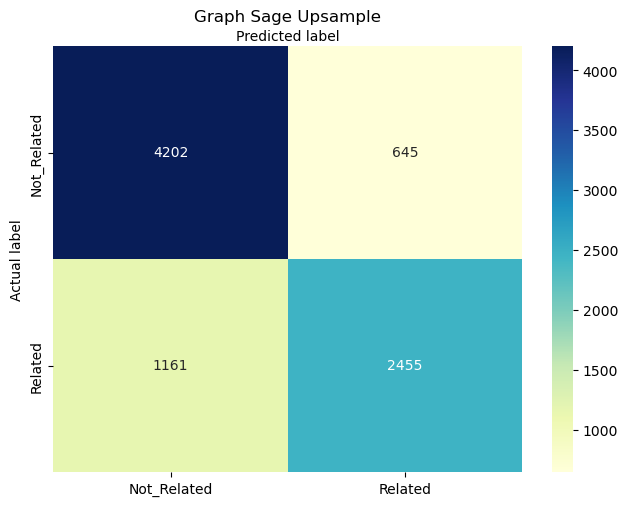

In [25]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n = metrics.confusion_matrix(clabels[cidx_test], cout[cidx_test])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
cnf_matrix_n[0][0]

4202

In [27]:
import sklearn

In [28]:
print(sklearn.metrics.classification_report(clabels[cidx_test], cout[cidx_test], target_names=class_names))

              precision    recall  f1-score   support

 Not_Related       0.78      0.87      0.82      4847
     Related       0.79      0.68      0.73      3616

    accuracy                           0.79      8463
   macro avg       0.79      0.77      0.78      8463
weighted avg       0.79      0.79      0.78      8463



In [29]:
cnf_matrix_n

array([[4202,  645],
       [1161, 2455]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

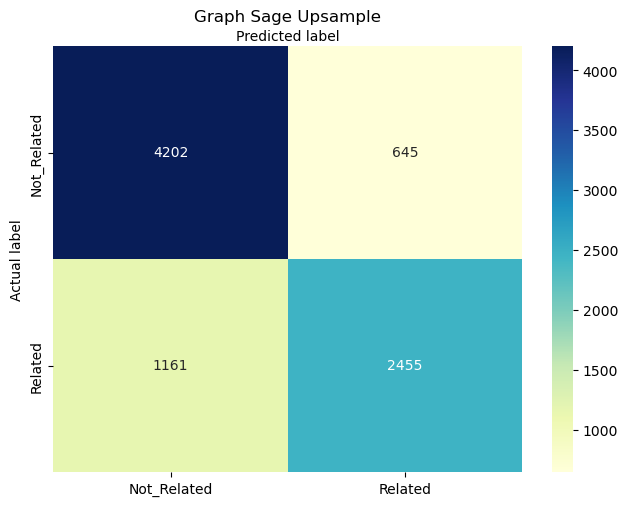

In [30]:
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt 
cnf_matrix_n_valid = metrics.confusion_matrix(clabels[cidx_valid], cout[cidx_valid])
class_names=["Not_Related", "Related"]
#class_names=["Not_Related", "1","2","3"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
sns.heatmap(cnf_matrix_n, annot=True, cmap="YlGnBu" ,fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Graph Sage Upsample')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
false_positive_test=cnf_matrix_n[0][1]
true_positive_test=cnf_matrix_n[1][1]
true_negative_test=cnf_matrix_n[0][0]
false_negative_test=cnf_matrix_n[1][0]

false_positive_valid=cnf_matrix_n_valid[0][1]
true_positive_valid=cnf_matrix_n_valid[1][1]
true_negative_valid=cnf_matrix_n_valid[0][0]
false_negative_valid=cnf_matrix_n_valid[1][0]

In [32]:
def specificity(true_negative,false_positive):
    return str(true_negative/(true_negative+false_positive))
def sensitivity(true_positive,false_negative):
    return str(true_positive/(true_positive+false_negative))

In [33]:
print('test')
print("Specificity: "+ specificity(true_negative_test,false_positive_test))
print("Sensitivity: "+ sensitivity(true_positive_test,false_negative_test))


test
Specificity: 0.866927996698989
Sensitivity: 0.6789269911504425


In [34]:
print('validation')
print("Specificity: "+ specificity(true_negative_valid,false_positive_valid))
print("Sensitivity: "+sensitivity(true_positive_valid,false_negative_valid))


validation
Specificity: 0.8816666666666667
Sensitivity: 0.6941666666666667


In [35]:
test_labels=clabels[cidx_test]
test_output=cout[cidx_test]
valid_labels=clabels[cidx_valid]
valid_output=cout[cidx_valid]

In [36]:
test_labels_enc=np.eye(4)[test_labels]
test_output_enc=np.eye(4)[test_output]
valid_labels_enc=np.eye(4)[valid_labels]
valid_output_enc=np.eye(4)[valid_output]

In [37]:
roc_auc_score(clabels[cidx_test], cout[cidx_test])

0.7729274939247158

In [38]:
roc_auc_score(clabels[cidx_valid], cout[cidx_valid])

0.7879166666666668